<a href="https://colab.research.google.com/github/shreyab1111/MultiLexNorm-Challenge/blob/main/Deutsch/de_ln_seq2seq_biLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate
from tensorflow.keras import Input, Model

German

In [10]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 128  # Latent dimensionality of the encoding space.
num_samples = 30000  # Number of samples to train on.
data_path = '/content/drive/MyDrive/NLP/Lexical Normalisation/Multilexnorm Challenge/German/de.train.norm.txt'

Character encoding

In [11]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r") as f:
    lines = f.readlines()
for line in lines[: min(num_samples, len(lines) - 1)]:
  if line=='\n':
    continue
  else:
    input_text, target_text= line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 15006
Number of unique input tokens: 130
Number of unique output tokens: 130
Max sequence length for inputs: 35
Max sequence length for outputs: 38


In [12]:
input_texts

['Einer',
 'bösen',
 'Kundenmail',
 'grade',
 'ganz',
 'lieb',
 'und',
 'nett',
 'gewantwortet',
 'ich',
 'Unser',
 'Versammlungsleiter',
 'hat',
 "'",
 'Rot-Grün-Schwäche',
 ',',
 'das',
 'hätte',
 'man',
 'vor',
 'der',
 'Wahl',
 'wissen',
 'sollen',
 '...',
 'offenbings',
 'bpt112',
 'vor',
 'allem',
 'machen',
 'die',
 'bei',
 'uns',
 'so',
 'ein',
 'Hype',
 'darum',
 ',',
 'nur',
 'weils',
 'heute',
 'in',
 'Friedrichshafen',
 'ist',
 'Seit',
 'gestern',
 'gibts',
 'auf',
 'dem',
 'Stupidozid',
 'Youtube',
 'Kanal',
 'den',
 'alljährlichen',
 'Abfallkalender',
 '.',
 'Jeden',
 'tag',
 'ein',
 'Türchen',
 'mit',
 '...',
 'oooh',
 ',',
 'hab',
 'ich',
 'nicht',
 'gesehn',
 '.',
 'wie',
 'geht',
 "'s",
 'dir',
 '?',
 '♥',
 'Morgens',
 'um',
 '7',
 'aufstehen',
 'um',
 'irgendwelche',
 'dubiosen',
 'Physikarbeiten',
 'zu',
 'schreiben',
 '...',
 'Wenigstens',
 'wartet',
 'ein',
 'Wundesschöner',
 'Student',
 'mit',
 'mir',
 'an',
 'der',
 'H',
 'Folgt',
 'mal',
 'alle',
 'der',
 '@use

encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.

decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.

decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

In [13]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

one hot rep

In [14]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[',']] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, (t + 1):, target_token_index[',']] = 1.0
    decoder_target_data[i, t:, target_token_index[',']] = 1.0

In [15]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = encoder(encoder_inputs)

state_h = Concatenate()([forw_state_h, back_state_h])
state_c = Concatenate()([forw_state_c, back_state_c])

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM((2*latent_dim), return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [16]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/100
188/188 [==============================] - 15s 53ms/step - loss: 0.5915 - accuracy: 0.8568 - val_loss: 0.4330 - val_accuracy: 0.8752
Epoch 2/100
188/188 [==============================] - 8s 42ms/step - loss: 0.3647 - accuracy: 0.9057 - val_loss: 0.3053 - val_accuracy: 0.9185
Epoch 3/100
188/188 [==============================] - 8s 40ms/step - loss: 0.2411 - accuracy: 0.9378 - val_loss: 0.1849 - val_accuracy: 0.9511
Epoch 4/100
188/188 [==============================] - 8s 40ms/step - loss: 0.1613 - accuracy: 0.9581 - val_loss: 0.1308 - val_accuracy: 0.9691
Epoch 5/100
188/188 [==============================] - 8s 41ms/step - loss: 0.1157 - accuracy: 0.9704 - val_loss: 0.0987 - val_accuracy: 0.9741
Epoch 6/100
188/188 [==============================] - 8s 40ms/step - loss: 0.0882 - accuracy: 0.9772 - val_loss: 0.0799 - val_accuracy: 0.9800
Epoch 7/100
188/188 [==============================] - 8s 40ms/step - loss: 0.0712 - accuracy: 0.9817 - val_loss: 0.0724 - val_accuracy

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


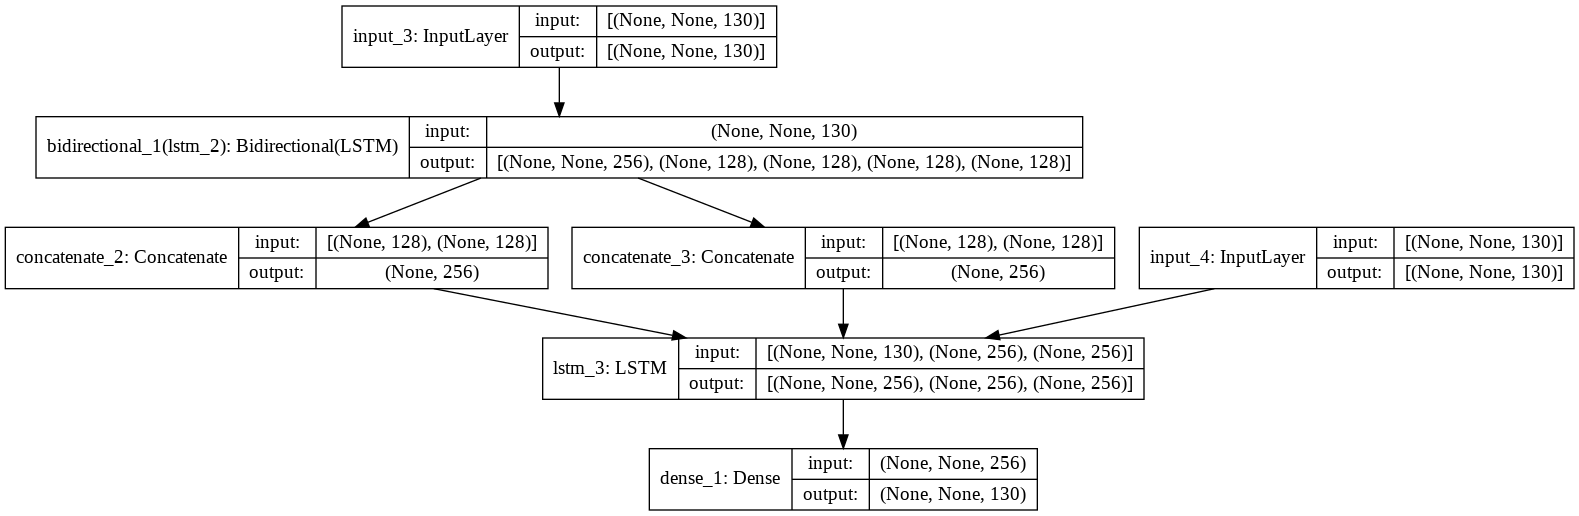

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

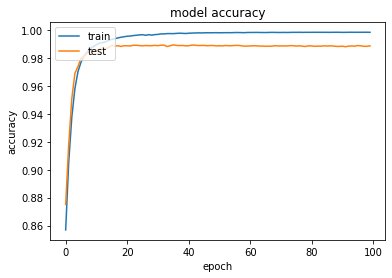

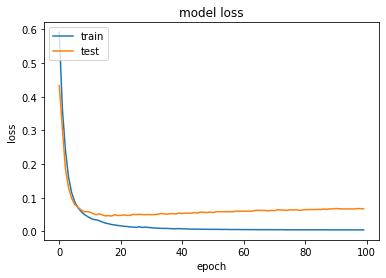

In [18]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

testing with validation

In [20]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = model.layers[1].output # lstm_1
state_h_enc = Concatenate()([forw_state_h, back_state_h])
state_c_enc = Concatenate()([forw_state_c, back_state_c])
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=((2*latent_dim),), name="input_7")
decoder_state_input_c = keras.Input(shape=((2*latent_dim),), name="input_5")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[5]
initial_state=decoder_states_inputs
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=initial_state)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [21]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Einer
Decoded sentence: Einer

-
Input sentence: bösen
Decoded sentence: bösen

-
Input sentence: Kundenmail
Decoded sentence: Kundenmail

-
Input sentence: grade
Decoded sentence: gerade

-
Input sentence: ganz
Decoded sentence: ganz

-
Input sentence: lieb
Decoded sentence: lieb

-
Input sentence: und
Decoded sentence: und

-
Input sentence: nett
Decoded sentence: nett

-
Input sentence: gewantwortet
Decoded sentence: geantwortet

-
Input sentence: ich
Decoded sentence: ich

-
Input sentence: Unser
Decoded sentence: Unser

-
Input sentence: Versammlungsleiter
Decoded sentence: Versammlungsleiter

-
Input sentence: hat
Decoded sentence: hat

-
Input sentence: '
Decoded sentence: '

-
Input sentence: Rot-Grün-Schwäche
Decoded sentence: Rot-Grün-Schwäche

-
Input sentence: ,
Decoded sentence: ,

-
Input sentence: das
Decoded sentence: das

-
Input sentence: hätte
Decoded sentence: hätte

-
Input sentence: man
Decoded sentence: man

-
Input sentence: vor
Decoded sentenc